# **Predicting Continuous Target Variables with Regression Analysis**

**Outline:**

- Introducing regression
    - Simple linear regression

- Exploring the Ames Housing Dataset
    - Loading the Ames Housing dataset into a data frame
    - Visualizing the important characteristics of a dataset

- Implementing an ordinary least squares linear regression model
    - Solving regression for regression parameters with gradient descent
    - Estimating the coefficient of a regression model via scikit-learn

- Fitting a robust regression model using RANSAC
- Evaluating the performance of linear regression models
- Using regularized methods for regression
- Turning a linear regression model into a curve - polynomial regression
    - Modeling nonlinear relationships in the Ames Housing dataset
    - Dealing with nonlinear relationships using random forests
        - Decision tree regression
        - Random forest regression

- Summary

In [33]:
from IPython.display import Image
%matplotlib inline

`Regression models` are used to predict target variables on a continuous scale, which makes them attractive for addressing many questions in science. They also have applications in industry, such as understanding relationships between variables, evaluating trends, or making forecasts. One example is predicting the sales of a company in future months.

## **Introducing linear regression**

The goal of linear regression is to model the relationship between one or multiple features and a continuous target variable. In contrast to classification—a different subcategory of supervised learning regression analysis aims to predict outputs on a continuous scale rather than categorical class labels.



### **Simple linear regression**

The goal of simple `(univariate)` linear regression is to model the relationship between a single feature (`explanatory variable`, $x$) and a continuous-valued `target` (`response variable`, $y$). The equation of a linear model with one explanatory variable is defined as follows:

$$y = w_{1}x + b$$

where;

- $b$ (bias term), represents the `y` axis intercept, and
- $w_{1}$ is the weight coefficient of the explanatory variable.
- $y$ is the target variable

Our goal is to learn the weights of the linear equation to descirbe the relationship between the explanatory variable and the target variable, which can then be used to predict the responses of new explanatory variables that were not part of the training dataset.

- Linear regression can be understood as finding the best-fitting straight line through the training examples:

![One feature Linear regression](./figures/one-feature-linear-regression.png)

- The best fitting line is also called the `regression line`, and the vertical lines from the regression line to the training examples are the so-called `offsets` or `residuals` - the errors of our prediction.

### **Multiple linear regression**

The previous section introduced simple linear regression, a special case of linear regression with one explanatory variable. Of course, we can also generalize the linear regression model to multiple explanatory variables; this process is called `multiple linear regression`:


$$y = w_{1}x_{1} + ... + w_{m}x_{m} + b = \sum^{m}_{i = 1} w_{i}x_{i} + b = w^{T}x + b $$

![Two feature multi-linear regression](./figures/two-feature-multi-linear-regression.png)

## **Exploring the Ames Housing dataset**

- A report describing the dataset: http://jse.amstat.org/v19n3/decock.pdf

- Detailed documentation regarding the dataset’s features: http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

- The dataset in a tab-separated format: http://jse.amstat.org/v19n3/decock/AmesHousing.
txt

#### **Loading the Ames Housing dataset into a DataFrame**

The features we will be working with, including the target variable, are as follows:

- `Overall Qual:` Rating for the overall material and finish of the house on a scale from 1 (very poor) to 10 (excellent)

    - 10 Very Excellent
    - 9	Excellent
    - 8	Very Good
    - 7	Good
    - 6	Above Average
    - 5	Average
    - 4	Below Average
    - 3	Fair
    - 2	Poor
    - 1	Very Poor


- `Overall Cond:` Rating for the overall condition of the house on a scale from 1 (very poor) to 10 (excellent)

    - 10 Very Excellent
    - 9	Excellent
    - 8	Very Good
    - 7	Good
    - 6	Above Average	
    - 5	Average
    - 4	Below Average	
    - 3	Fair
    - 2	Poor
    - 1	Very Poor


- `Gr Liv Area:` Above grade (ground) living area in square feet


- `Central Air:` Central air conditioning (N=no, Y=yes)

    - N	No
    - Y	Yes

- `Total Bsmt SF:` Total square feet of the basement area

- `SalePrice:` Sale price in U.S. dollars ($)


The target variable = `sale price (SalePrice)`, the variable we want to predict using one or more of the five explanatory variables. 

In [8]:
import pandas as pd

columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
           'Central Air', 'Total Bsmt SF', 'SalePrice']

data_path = "../data/AmesHousing.csv"

df = pd.read_csv(data_path, usecols=columns)

df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [9]:
df.columns

Index(['Overall Qual', 'Overall Cond', 'Total Bsmt SF', 'Central Air',
       'Gr Liv Area', 'SalePrice'],
      dtype='object')

In [10]:
df.shape

(2930, 6)

- Convert the string `Y` to the integer `1`, and the string `N` to the integer `0`:

In [11]:
df["Central Air"].unique()

array(['Y', 'N'], dtype=object)

In [12]:
df["Central Air"] = df["Central Air"].map({'N': 0, 'Y': 1})

In [13]:
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,1,1656,215000
1,5,6,882.0,1,896,105000
2,6,6,1329.0,1,1329,172000
3,7,5,2110.0,1,2110,244000
4,5,5,928.0,1,1629,189900


In [14]:
# check for missing values
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

As we can see, the `Total Bsmt SF` feature variable contains one missing value. Since we have a relatively large dataset, the easiest way to deal with this missing feature value is to remove the corresponding example from the dataset.

In [15]:
df = df.dropna(axis=0)
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

### **Visualizing the important characteristics of a dataset**

`Exploratory data analysis (EDA)` is an important and recommended first step prior to the training of a machine learning model. In the rest of this section, we will use some simple yet useful techniques from the graphical EDA toolbox that may help us to visually detect the presence of outliers, the distribution of the data, and the relationships between features.

In [16]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

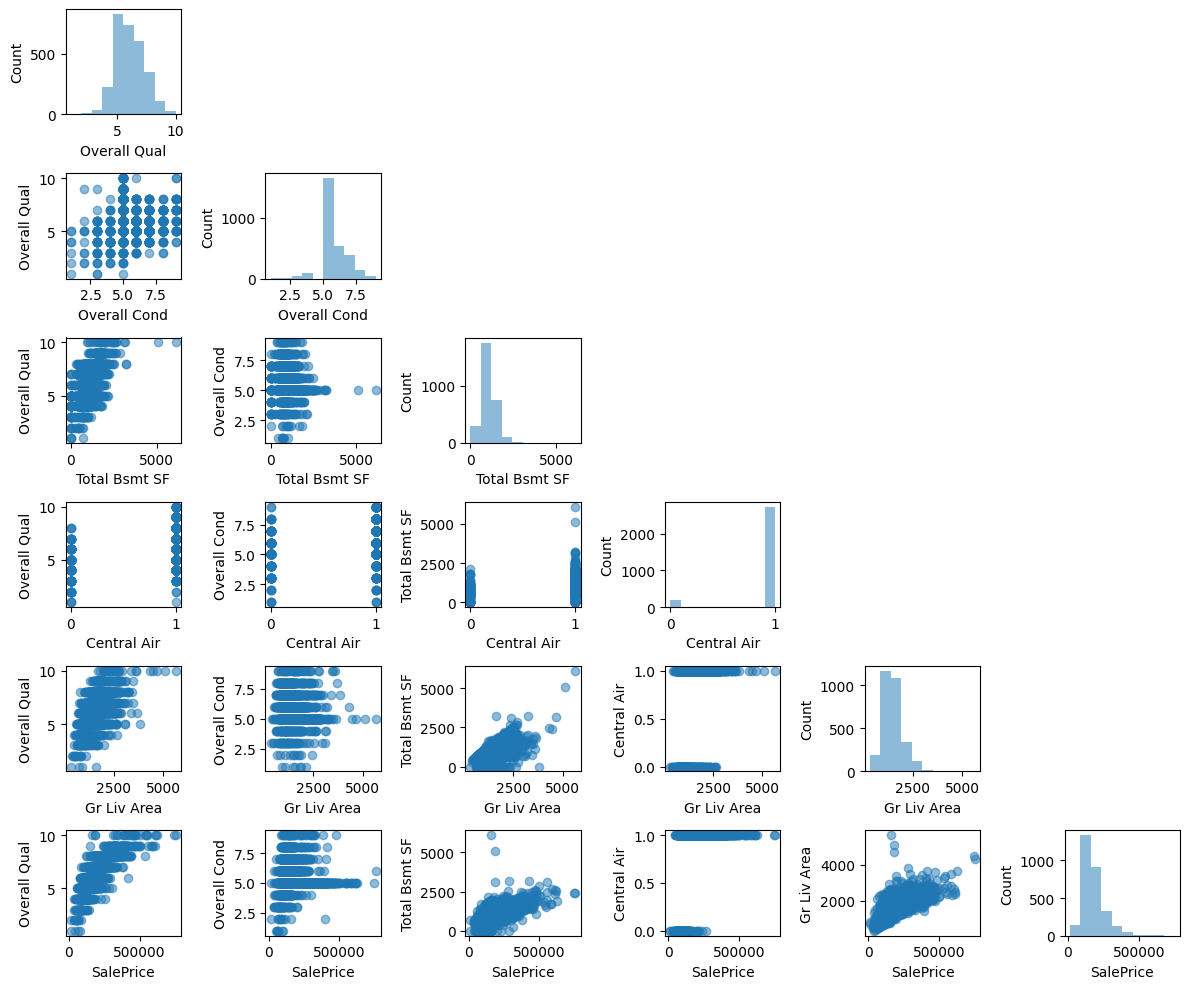

In [17]:
scatterplotmatrix(df.values, figsize=(12, 10), 
                  names=df.columns, alpha=0.5)

plt.tight_layout()
#plt.savefig('figures/09_04.png', dpi=300)
plt.show()

- Using this scatterplot matrix, we can now quickly see how the data is distributed and whether it contains outliers. For example, we can see (fifth column from the left of the bottom row) that there is a somewhat linear relationship between the size of the `living area` above ground `(Gr Liv Area)` and the `sale price (SalePrice)`.

- Furthermore, we can see in the histogram—the lower-right subplot in the scatterplot matrix—that the SalePrice variable seems to be skewed by several outliers.

### **Looking at relationships using a correlation matrix**

- create a correlation matrix to quantify and summarize linear relationships between variables.

- correlation matrix is closely related to the covariance matrix.

- correlation matrix is a square matrix that contains the `Pearson product-moment correlation coefficient`, which measures the linear dependence between pairs of features.

- In the range of `-1 to 1`.

- Two features have a perfect positive correlation if `r = 1`, no correlation if `r = 0`, and a perfect negative correlation if `r = -1`.

- Pearson's correlation coefficient can simply be calculated as the covariance between two features, $x$ and $y$ (numerator), divided by the product of their `standard deviations (denominator)`.


**Formula:**

$$r = \dfrac{\mathrm{cov}(x, y)}{\sigma_x \sigma_y}$$

or equivalently,

$$r = \dfrac{\sum_{i=1}^{n} (x_i - \mu_x)(y_i - \mu_y)}{\sqrt{\sum_{i=1}^{n} (x_i - \mu_x)^2} \sqrt{\sum_{i=1}^{n} (y_i - \mu_y)^2}}$$


**Interpretation:**
The **Pearson correlation coefficient** ($r$) measures the **strength and direction of the linear relationship** between two variables.

* $r = 1$: perfect positive linear correlation
* $r = -1$: perfect negative linear correlation
* $r = 0$: no linear correlation

* $\mu$ denotes the mean of the corresponding features
* $\sigma_{xy}$ is the covariance between the features `x` and `y`, and
* $\sigma_{x}$ and $\sigma_{y}$ are the features' standard deviations.


**Covariance versus correlation for standardized features**

We can show that the covariance between a pair of standardized features is, in fact, equal to their linear correlation coefficient

For standardized variables $x'$ and $y'$:

$$x' = \dfrac{x - \mu_x}{\sigma_x}, \quad y' = \dfrac{y - \mu_y}{\sigma_y}$$

The covariance between $x'$ and $y'$ is:

$$\mathrm{cov}(x', y') = \dfrac{1}{n} \sum_{i=1}^{n} (x_i' - 0)(y_i' - 0)$$

Substituting the standardized form:

$$\mathrm{cov}(x', y') = \dfrac{1}{n} \sum_{i=1}^{n} \left( \dfrac{x_i - \mu_x}{\sigma_x} \right) \left( \dfrac{y_i - \mu_y}{\sigma_y} \right)$$

Simplifies to:

$$\mathrm{cov}(x', y') = \dfrac{\mathrm{cov}(x, y)}{\sigma_x \sigma_y}$$


**Interpretation:**
The covariance of two **standardized features** (zero mean, unit variance) is **equal to their correlation coefficient**.

Hence,
$$\mathrm{cov}(x', y') = r_{xy}$$

This means when features are standardized, **covariance directly measures correlation**, making correlation a **scale-invariant version** of covariance.


- plot the correlation matrix array as a heat map

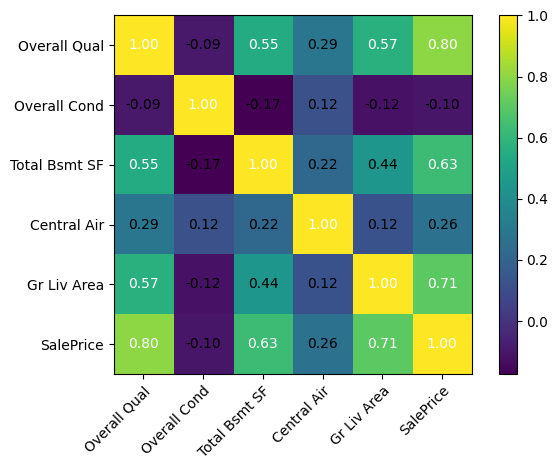

In [ ]:
import numpy as np
from mlxtend.plotting import heatmap

cm = np.corrcoef(df.values.T)
hm = heatmap(cm, row_names=df.columns, column_names=df.columns)

plt.tight_layout()
#plt.savefig('figures/09_05.png', dpi=300)
plt.show()

To fit a linear regression model, we are interested in those features that have a high correlation with our target variable, `SalePrice`. Looking at the correlation matrix, we can see that `SalePrice` shows the largest correlation with the `Gr Liv Area` variable (0.71), which seems to be a good choice for an exploratory variable to introduce the concepts of a simple linear regression model.

## **Implementing an ordinary least squares linear regression model**

- `Ordinary Least Squares (OLS)` method estimates the parameters of the linear regression line that minimizes the sum of the squared vertical distances (residuals or errors) to the training examples.

### **Ordinary Least Squares (OLS)**


### **1. Overview**

Ordinary Least Squares (OLS) is a **linear regression method** that estimates the relationship between a dependent variable $`y`$ and one or more independent variables $`X`$.

The goal is to find the best-fitting line (or hyperplane) that minimizes the **sum of squared residuals (errors)** between predicted and observed values.



### **2. Mathematical Formulation**

Given:

$$y = X\beta + \varepsilon$$

Where:

* $`y \in \mathbb{R}^{n \times 1}`$ → vector of observed outputs
* $`X \in \mathbb{R}^{n \times p}`$ → matrix of input features (with a column of 1s for intercept)
* $`\beta \in \mathbb{R}^{p \times 1}`$ → vector of coefficients to estimate
* $`\varepsilon \in \mathbb{R}^{n \times 1}`$ → random errors (assumed mean zero, independent, homoscedastic)

Objective function (Loss):

$$J(\beta) = \sum_{i=1}^{n} (y_i - X_i \beta)^2 = (y - X\beta)^\mathrm{T} (y - X\beta)$$



### **3. Derivation of the OLS Estimator**

To minimize $`J(\beta)`$, differentiate with respect to $`\beta`$ and set to zero:

$$\dfrac{\partial J}{\partial \beta} = -2X^\mathrm{T}(y - X\beta) = 0$$

Solving for $`\beta`$ gives:

$$\hat{\beta} = (X^\mathrm{T} X)^{-1} X^\mathrm{T} y$$



### **4. Geometric Interpretation**

* $`y`$ lies in $`\mathbb{R}^n`$.
* $`X\beta`$ represents a projection of $`y`$ onto the **column space of** $`X`$.
* The OLS solution finds the projection $`\hat{y} = X\hat{\beta}`$ that minimizes the perpendicular distance between $`y`$ and this subspace.

Thus,

$$\hat{y} = P_X y, \quad \text{where } P_X = X(X^\mathrm{T} X)^{-1} X^\mathrm{T}$$

is the **projection matrix** onto the column space of $`X`$.



### **5. Residuals**

Residual vector:

$$\hat{\varepsilon} = y - \hat{y} = (I - P_X)y$$

Properties:

* $`X^\mathrm{T} \hat{\varepsilon} = 0`$ → residuals are orthogonal to predictors.

* $`\hat{\varepsilon}^\mathrm{T} \hat{y} = 0`$ → fitted values and residuals are uncorrelated.




### **6. Statistical Properties**

Under the classical assumptions (linearity, independence, homoscedasticity, normality):

1. **Unbiasedness**:
   $$\mathbb{E}[\hat{\beta}] = \beta$$

2. **Variance of Estimator**:
   $$\mathrm{Var}(\hat{\beta}) = \sigma^2 (X^\mathrm{T} X)^{-1}$$, where $$\sigma^2 = \mathrm{Var}(\varepsilon)$$

3. **Efficiency (Gauss–Markov Theorem)**:
   OLS is the **Best Linear Unbiased Estimator (BLUE)** — no other linear unbiased estimator has a smaller variance.

4. **Sampling Distribution** (if errors are normal):
   $$\hat{\beta} \sim \mathcal{N}(\beta, \sigma^2 (X^\mathrm{T} X)^{-1})$$



### **7. Model Evaluation Metrics**

* **Residual Sum of Squares (RSS):**
  $$\mathrm{RSS} = \sum (y_i - \hat{y}_i)^2$$

* **Total Sum of Squares (TSS):**
  $$\mathrm{TSS} = \sum (y_i - \bar{y})^2$$

* **Coefficient of Determination (R²):**
  $$R^2 = 1 - \dfrac{\mathrm{RSS}}{\mathrm{TSS}}$$
  Measures the proportion of variance in $`y`$ explained by $`X`$.

* **Adjusted R²:**
  $$R^2_{adj} = 1 - (1 - R^2)\dfrac{n - 1}{n - p - 1}$$
  Adjusts for number of predictors to avoid overfitting.



### **8. Assumptions Recap**

| Assumption           | Description                            | Implication if Violated               |
| -------------------- | -------------------------------------- | ------------------------------------- |
| Linearity            | Relationship between X and y is linear | Biased estimates                      |
| Independence         | Residuals are independent              | Invalid inference                     |
| Homoscedasticity     | Constant variance of errors            | Inefficient estimates                 |
| Normality            | Errors are normally distributed        | Invalid confidence intervals/p-values |
| No Multicollinearity | Predictors not highly correlated       | Unstable estimates                    |



### **9. Limitations**

* Sensitive to **outliers**.
* Assumes **linear relationship**.
* Poor performance under **multicollinearity** or **heteroscedasticity**.
* Cannot handle **nonlinear interactions** without feature engineering.



### **10. Extensions**

| Extension                 | Description                        |
| ------------------------- | ---------------------------------- |
| Ridge Regression          | Adds `L2` penalty to reduce variance |
| Lasso Regression          | Adds `L1` penalty to induce sparsity |
| Elastic Net               | Combines `L1` and `L2` regularization  |
| Generalized Linear Models | Extends `OLS` for non-normal errors  |
| Weighted Least Squares    | Accounts for heteroscedasticity    |
| Robust Regression         | Reduces sensitivity to outliers    |


OLS minimizes squared errors to find the best linear fit. It’s the foundation of regression analysis, with deep links to **geometry, statistics, and optimization**. Despite its simplicity, understanding OLS builds intuition for advanced models like **regularized regression, GLMs, and neural networks**.


### **Solving regression for regression parameters with gradient descent**

In [31]:
df["SalePrice"].describe()

count      2929.000000
mean     180830.814612
std       79878.175546
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [19]:
class LinearRegressionGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.W_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.array([0.])
        self.losses_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.W_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.W_) + self.b_
    
    def predict(self, X):
        return self.net_input(X)

In [20]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

In [21]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()

X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

lr = LinearRegressionGD(eta=0.1)
lr.fit(X_std, y_std)

Notice the workaround regarding `y_std`, using `np.newaxis` and `flatten`. Most data preprocessing classes in scikit-learn expect data to be stored in two-dimensional arrays. In the previous code example, the use of `np.newaxis` in `y[:, np.newaxis]` added a new dimension to the array. Then, after `StandardScaler` returned the scaled variable, we converted it back to the original one-dimensional array representation using the `flatten()` method for our convenience.

In [62]:
# del range

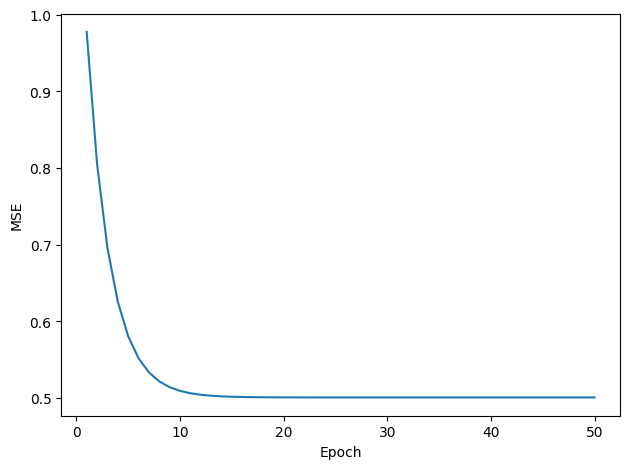

In [63]:
plt.plot(range(1, lr.n_iter+1), lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.tight_layout()
#plt.savefig('figures/09_06.png', dpi=300)
plt.show()

- Next, let’s visualize how well the linear regression line fits the training data. To do so, we will define a simple helper function that will plot a scatterplot of the training examples and add the regression line:

In [64]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    
    return

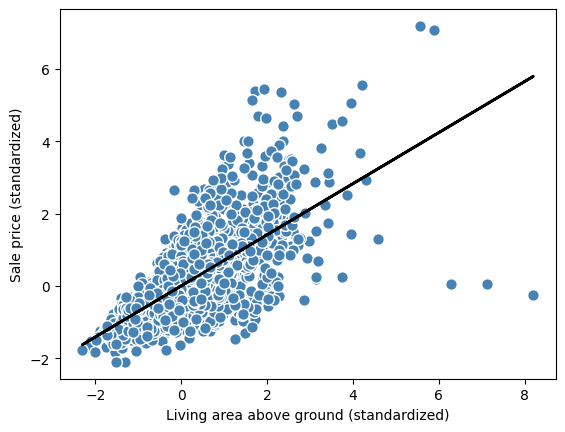

In [65]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Living area above ground (standardized)')
plt.ylabel('Sale price (standardized)')

#plt.savefig('figures/09_07.png', dpi=300)
plt.show()

- Although this observation makes sense, the data also tells us that the living area size does not explain house prices very well in many cases. 

- In certain applications, it may also be important to report the predicted outcome variables on their original scale. To scale the predicted price back onto the original price in `U.S. dollars` scale, we can simply apply the `inverse_transform` method of `StandardScaler:`

In [66]:
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr.predict(feature_std)

target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))
print(f'Sale price: ${target_reverted.flatten()[0]:.2f}')

Sale price: $292507.07


- In this code example, we used the previously trained linear regression model to predict the price of a house with an aboveground living area of `2,500` square feet. According to our model, such a house will be worth `$292,507.07`.

- As a side note, it is also worth mentioning that we technically don’t have to update the intercept parameter (for instance, the bias unit, $b$) if we are working with standardized variables, since the $y$ axis intercept is always `0` in those cases. We can quickly confirm this by printing the model parameters:

In [68]:
print(f'Slope: {lr.W_[0]:.3f}')
print(f'Intercept: {lr.b_[0]:.3f}')

Slope: 0.707
Intercept: -0.000


### **Estimating the coefficient of a regression model via scikit-learn**

In [69]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)

print(f'Slope: {slr.coef_[0]:.3f}')

Slope: 111.666


In [70]:
print(f'Intercept: {slr.intercept_:.3f}')

Intercept: 13342.979


- As you can see from executing this code, scikit-learn’s `LinearRegression` model, fitted with the unstandardized `Gr Liv Area` and `SalePrice` variables, yielded different model coefficients, since the features have not been standardized. However, when we compare it to our `GD` implementation by plotting `SalePrice` against `Gr Liv Area`, we can qualitatively see that it fits the data similarly well:

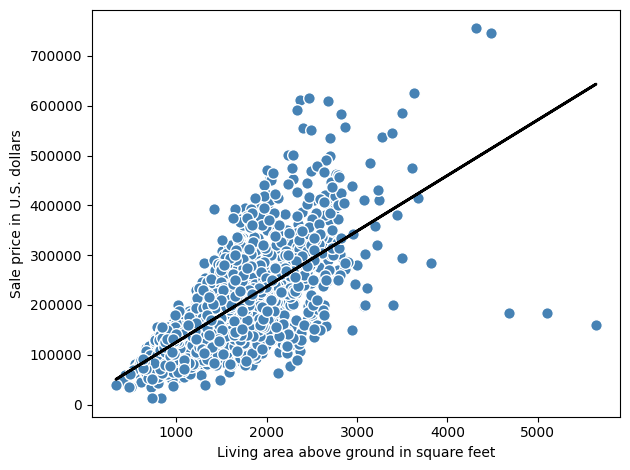

In [71]:
lin_regplot(X, y, slr)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')

plt.tight_layout()
#plt.savefig('figures/09_08.png', dpi=300)
plt.show()

**Normal Equations alternative:**

As an alternative to using machine learning libraries, there is also a closed-form solution for solving OLS involving a system of linear equations that can be found in most introductory statistics textbooks:

$$w = (X^{T}X)^{-1}X^{T}y$$

In [74]:
# adding a column vector of "ones"
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))

print(f'Slope: {w[1]:.3f}')
print(f'Intercept: {w[0]:.3f}')

Slope: 111.666
Intercept: 13342.979


The advantage of this method is that it is guaranteed to find the optimal solution analytically. However, if we are working with very large datasets, it can be computationally too expensive to invert the matrix in this formula (sometimes also called the normal equation), or the matrix containing the training examples may be singular (non-invertible), which is why we may prefer iterative methods in certain cases.

### **Fitting a robust regression model using RANSAC**

Linear regression models can be heavily impacted by the presence of outliers. In certain situations, a very small subset of our data can have a big effect on the estimated model coefficients. Many statistical tests can be used to detect `outliers`.


As an alternative to throwing out outliers, we will look at a robust method of regression using the `RANdom SAmple Consensus (RANSAC)` algorithm, which fits a regression model to a subset of the data, the so-called `inliers`.

**We can summarize the iterative RANSAC algorithm as follows:**

- Select a random number of examples to be inliers and fit the model.

- Test all other data points against the fitted model and add those points that fall within a user-given tolerance to the inliers.

- Refit the model using all inliers.

- Estimate the error of the fitted model versus the inliers.

- Terminate the algorithm if the performance meets a certain user-defined threshold or if a fixed number of iterations was reached; go back to step 1 otherwise.

- Let’s now use a linear model in combination with the RANSAC algorithm as implemented in scikit-learn’s `RANSACRegressor` class:

In [75]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=100, # default values
    min_samples=0.95,
    residual_threshold=None, # default value
    random_state=123
)
ransac.fit(X, y)

RANSACRegressor(estimator=LinearRegression(), min_samples=0.95,
                random_state=123)

- We set the maximum number of iterations of the `RANSACRegressor` to 100, and using `min_sample=0.95`, we set the minimum number of the randomly chosen training examples to be at least 95 percent of the dataset.

- By default (via `residual_threshold=None`), scikit-learn uses the `MAD` estimate to select the inlier threshold, where `MAD` stands for the `median absolute deviation` of the target values, `y`. However, the choice of an appropriate value for the inlier threshold is problem-specific, which is one disadvantage of RANSAC.

- Once we have fitted the `RANSAC` model, let’s obtain the inliers and outliers from the fitted `RANSAC` linear regression model and plot them together with the linear fit:

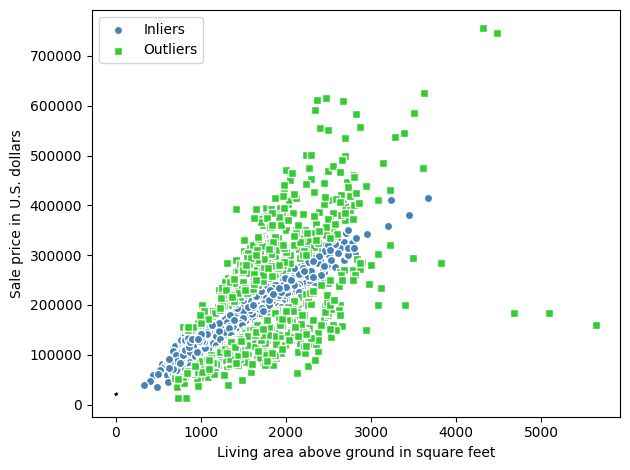

In [76]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolors='white',
            marker='o', label='Inliers')

plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolors='white',
            marker='s', label='Outliers')

plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

- As you can see, the linear regression model was fitted on the detected set of `inliers`. 

In [78]:
print(f"Slope: {ransac.estimator_.coef_[0]:.3f}")

Slope: 106.348


In [79]:
print(f"Intercept: {ransac.estimator_.intercept_:.3f}")

Intercept: 20190.093


- Remember that we set the `residual_` threshold parameter to `None`, so `RANSAC` was using the `MAD` to compute the threshold for flagging `inliers` and `outliers`. The `MAD`, for this dataset, can be computed as follows:

In [80]:
def mean_absolute_deviation(data):
    return np.mean(np.abs(data - np.mean(data)))

mean_absolute_deviation(y)

np.float64(58269.561754979375)

- If we want to identify fewer data points as outliers, we can choose a `residual_threshold` value greater than the preceding `MAD`.

- We can set the linear regression model with a residual threshold of `65,000`:

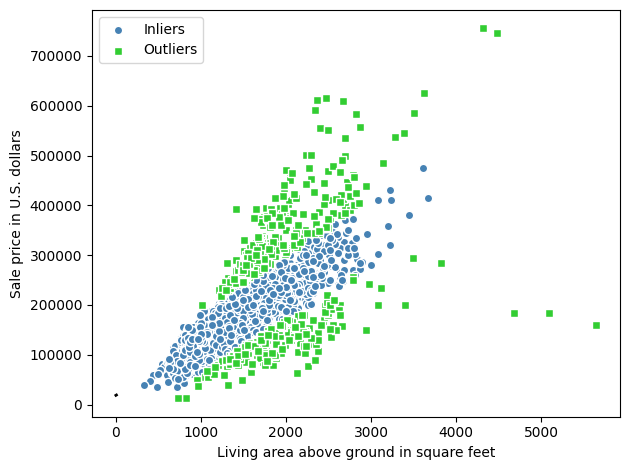

In [81]:
ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, # default
                         min_samples=0.95, 
                         loss='absolute_error', # default
                         residual_threshold=65000, # default 
                         random_state=123)

ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/09_10.png', dpi=300)
plt.show()

In [82]:
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Slope: 105.631
Intercept: 18314.587


## **Evaluating the performance of linear regression models**

- Obtaining a more unbiased estimate of generalization performance of the `estimator`.

In [83]:
from sklearn.model_selection import train_test_split

target = "SalePrice"
features = df.columns[df.columns != target]

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)

In [84]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

- Since our model uses multiple explanatory variables, we can visualize the linear regression line (or hyperplane, to be precise) in a two-dimensional plot, but we can plot the residual (the difference or vertical distances between the actual and predicted values) versus the predicted values to diagnose our regression model.

- `Residual plots` are a commonly used graphical tool for diagnosing regression models. They can help to detect nonlinearity and outliers and check whether the errors are randomly distributed.

- plot the residual plot where we simply subtract the true target variables from our predicted responses:

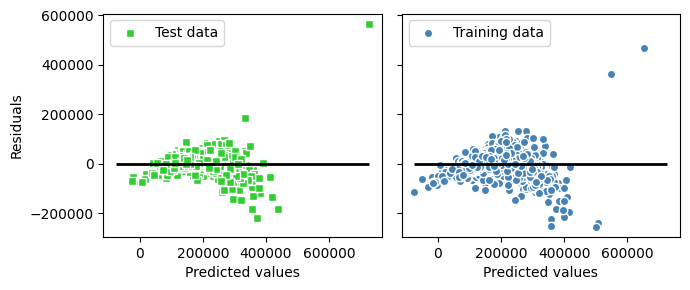

In [85]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()

#plt.savefig('figures/09_11.png', dpi=300)
plt.show()

- In the case of a `perfect prediction`, the `residuals` would be exactly zero, which we will probably never encounter in realistic and practical applications. However, for a good regression model, we would expect the errors to be randomly distributed and the `residuals` to be randomly scattered around the centerline. If we see patterns in a residual plot, it means that our model is unable to capture some explanatory information, which has leaked into the `residuals`, as you can see to a degree in our previous residual plot. Furthermore, we can also use residual plots to detect outliers, which are represented by the points with a large deviation from the centerline.


- Another useful quantitative measure of a model’s performance is the `mean squared error (MSE)` that we discussed earlier as our loss function that we minimized to fit the linear regression model. The following is a version of the `MSE` without the $\frac {1}{2}$ scaling factor that is often used to simplify the loss derivative in gradient descent:

$$MSE = \frac {1}{n} \sum_{i=1}^{n}(y^{(i)} - \hat{y}^{(i)})^{2}$$

- Let’s now compute the `MSE` of our training and test predictions:

In [86]:
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f'MSE train: {mse_train:.2f}')
print(f'MSE test: {mse_test:.2f}')

MSE train: 1497216245.85
MSE test: 1516565821.00


- We can see that the MSE on the training dataset is larger than on the test set, which is an indicator that our model is slightly overfitting the training data in this case. Note that it can be more intuitive to show the error on the original unit scale (here, dollar instead of dollar-squared), which is why we may choose to compute the square root of the MSE, called `root mean squared error`, or the `mean absolute
error (MAE)`, which emphasizes incorrect prediction slightly less:


$$MAE = \frac {1}{n} \sum_{i=1}^{n} | (y^{(i)} - \hat{y}^{(i)}) |$$

- We can compute the `MAE` similar to the `MSE`:

In [87]:
from sklearn.metrics import mean_absolute_error

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')

MAE train: 25983.03
MAE test: 24921.29


### **Coefficient of Determination (R²)**


#### **1. Concept Overview**

The **Coefficient of Determination (R²)** measures how well a regression model explains the variability of the target variable.
It quantifies the proportion of variance in the dependent variable that is predictable from the independent variables.

In essence:

* $`R^2 = 1`$ → Perfect prediction (all points lie exactly on the regression line).
* $`R^2 = 0`$ → Model performs no better than predicting the mean.
* $`R^2 < 0`$ → Model performs worse than predicting the mean.



#### **2. Mathematical Definition**

Let:

* $`y_i`$ = actual values
* $`\hat{y}_i`$ = predicted values
* $`\bar{y}`$ = mean of actual values
* $`n`$ = number of samples

Then:

* **Total Sum of Squares (TSS):**
  $$TSS = \sum_{i=1}^{n}(y_i - \bar{y})^2$$

* **Residual Sum of Squares (RSS):**
  $$RSS = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

* **Coefficient of Determination:**
  $$R^2 = 1 - \frac{RSS}{TSS}$$



#### **3. Interpretation**

| R² Value | Interpretation                                  |
| -------- | ----------------------------------------------- |
| **≈ 1**  | Model explains nearly all variability in data   |
| **≈ 0**  | Model explains very little variability          |
| **< 0**  | Poor fit; predictions worse than using the mean |

Example:
If $`R^2 = 0.87`$, then **87%** of the variance in the target variable is explained by the model.



#### **4. Adjusted R²**

For multiple linear regression, adding more features can **artificially inflate R²**.
To correct this, use **Adjusted R²**, which penalizes unnecessary predictors:

$$R^2_{adj} = 1 - (1 - R^2)\frac{n - 1}{n - p - 1}$$

where:

* $`n`$ = number of samples
* $`p`$ = number of predictors

Adjusted R² **only increases** if the new predictor improves the model more than expected by chance.



#### **5. When to Use**

* **Use R²** to assess goodness-of-fit for **regression** models.
* **Don’t rely solely** on R²:

  * It doesn’t indicate *bias* or *causality*.
  * A high R² doesn’t guarantee a good predictive model.

Instead, complement it with:

* **RMSE / MAE** (for absolute error),
* **Cross-validation scores** (for generalization performance).



#### **6. Implementation (Scikit-learn)**

```python
from sklearn.metrics import r2_score

r2 = r2_score(y_true, y_pred)
print(f"R²: {r2:.3f}")
```


#### **7. Key Insight**

$`R^2`$ captures **how much better** your model is compared to a simple mean predictor.
It’s a **relative measure of fit**, not an absolute measure of predictive accuracy.


In [88]:
from sklearn.metrics import r2_score

r2_train = r2_score(y_train, y_train_pred)
r2_test =r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

R^2 train: 0.77
R^2 test: 0.75


### **Using regularized methods for regression**


**Regularization Methods**

Regularization prevents **overfitting** in regression or classification models by **penalizing large coefficients**. It adds a penalty term to the loss function to constrain model complexity.



#### **1. L1 Regularization (Lasso Regression)**
This approach can lead to sparse models. Depending on the regularization strength, certain weights can become zero, which also makes `LASSO` useful as a supervised feature selection technique:

**Penalty term:**

$$\lambda \sum_{j=1}^{p} |w_j|$$

Defined as sum of the absolute magnitude of the model weights.

* Encourages **sparsity** (many weights become zero).
* Performs **feature selection**.
* Useful when some features are irrelevant.



#### **2. L2 Regularization (Ridge Regression)**
We simply add the squared sum of the weights to the `MSE` loss function:

**Penalty term:**

$$\lambda \sum_{j=1}^{p} w_j^2$$

By increasing the value of hyperparameter $\lambda$, we increase the regularization strength and thereby shrink the weights of our model.  Also note that the bias term `b` is not regularized.

* Shrinks coefficients smoothly toward zero (but rarely to zero).
* Reduces variance without eliminating features.
* Useful when most features are relevant.



#### **3. Elastic Net**
A compromise between `ridge` regression and `LASSO` is elastic net, which has an `L1` penalty to generate sparsity and an `L2` penalty such that it can be used for selecting more than `n` features if `m` > `n`:

**Penalty term:**

$$\lambda [ \alpha \sum |w_j| + (1 - \alpha) \sum w_j^2 ]$$

* Combines **L1** and **L2** penalties.
* Balances sparsity and stability.
* Effective when features are correlated.



#### **When to Use**

| Scenario                 | Recommended Regularization |
| ------------------------ | -------------------------- |
| Many irrelevant features | **Lasso (L1)**             |
| All features useful      | **Ridge (L2)**             |
| Correlated features      | **Elastic Net**            |



**Core Idea:**
Regularization trades off **bias vs. variance**, improving generalization by discouraging overly complex models.


- Lasso regression:

In [89]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)

- Ridge regression:

In [90]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)

- Elastic Net regression:

In [91]:
from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

In [92]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1.0)

lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[26251.38276394   804.70816337    41.94651964 11364.80761309
    55.67855548]


In [93]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'MSE train: {train_mse:.3f}, test: {test_mse:.3f}')

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f'R^2 train: {train_r2:.3f}, {test_r2:.3f}')

MSE train: 1497216262.014, test: 1516576825.348
R^2 train: 0.769, 0.752


## **Turning a linear regression model into a curve - polynomial regression**


**Polynomial Regression — Summary**

Polynomial Regression models **nonlinear relationships** by extending Linear Regression with **polynomial features** of the input variable(s).

**Model form:**

$$y = w_{1}x + w_{2}x^2 + \dots + w_{n}x^n + b$$

**Key points:**

* Transforms input features using powers of (x) (e.g., (x^2, x^3, ...)).
* Still **linear in parameters** (fits via OLS).
* Captures curvature and complex trends.
* Requires careful choice of **degree (n)** to avoid **overfitting**.

**Implementation (sklearn):**
Use `PolynomialFeatures` with `LinearRegression`.


### **Adding polynomial terms using scikit-learn**

Using the `PolynomialFeatures` transformer class from scikit-learn to add a quadratic term `(d = 2)` to a simple regression problem with one explanatory variable. Then, we will compare the polynomial to the linear fit by following these steps:

- Add a second-degress polynomial term:

In [94]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

In [96]:
X.shape, y.shape

((10, 1), (10,))

In [95]:
from sklearn.preprocessing import PolynomialFeatures

lr = LinearRegression()
pr = LinearRegression()

quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

- Fit a simple linear regression model for comparison:

In [97]:
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

- Fit a multiple regression model on the transformed features for polynomial regression:

In [98]:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

- Plot the results

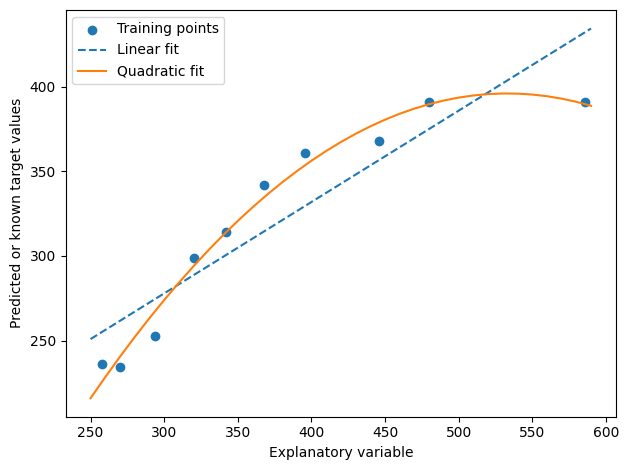

In [99]:
plt.scatter(X, y, label='Training points')
plt.plot(X_fit, y_lin_fit, label='Linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/09_12.png', dpi=300)
plt.show()

- From the plot above, you can see that the `polynomial` fit captures the relationship between the response and explanatory variables much better than the linear fit.

- Compute the `MSE` and $R^2$ evaluation metrics:

In [100]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

In [101]:
mse_lin = mean_squared_error(y, y_lin_pred)
mse_quad = mean_squared_error(y, y_quad_pred)
print(f'Training MSE linear: {mse_lin:.3f}'
      f', quadratic: {mse_quad:.3f}')


r2_lin = r2_score(y, y_lin_pred)
r2_quad = r2_score(y, y_quad_pred)
print(f'Training R^2 linear: {r2_lin:.3f}'
      f', quadratic: {r2_quad:.3f}')

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


- As you can see after executing the code, the MSE decreased from `570` (linear fit) to `61` (quadratic fit); also, the coefficient of determination reflects a closer fit of the quadratic model`(R2 = 0.982)` as opposed to the linear fit `(R2 = 0.832)` in this particular toy problem.

## **Modeling nonlinear relationships in the Ames Housing dataset**

- Modeling the relationship between sale prices and the living area above ground using second-degree (quadratic) and third-degree (cubic) polynomials and compare that to a linear fit.

- Remove outliers with a living area greater than `4,000` square feet.

In [102]:
df.columns

Index(['Overall Qual', 'Overall Cond', 'Total Bsmt SF', 'Central Air',
       'Gr Liv Area', 'SalePrice'],
      dtype='object')

In [103]:
df['Gr Liv Area'].shape

(2929,)

In [104]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

X = X[(df['Gr Liv Area'] < 4000)]
y = y[(df['Gr Liv Area'] < 4000)]

In [106]:
X.shape, y.shape

((2924, 1), (2924,))

- Fit the regression models:

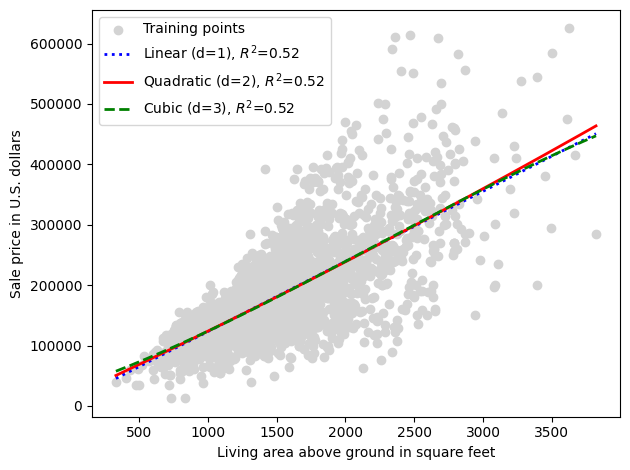

In [107]:
regr = LinearRegression()

# create quadratic and cubic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit to features
X_fit = np.arange(X.min()-1, X.max()+2, 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         color='green', 
         lw=2,
         linestyle='--')


plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('figures/09_13.png', dpi=300)
plt.show()

- As we can see, using quadratic or cubic features does not really have an effect. That’s because the relationship between the two variables appears to be linear. So, let’s take a look at another feature, namely, `Overall Qual`. The `Overall Qual` variable rates the overall quality of the material and finish of the houses and is given on a scale from 1 to 10, where 10 is best:

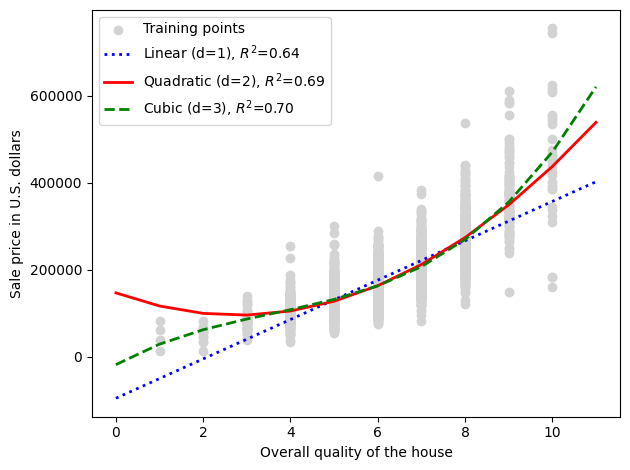

In [109]:
X = df[['Overall Qual']].values
y = df['SalePrice'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min()-1, X.max()+2, 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         color='green', 
         lw=2,
         linestyle='--')


plt.xlabel('Overall quality of the house')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/09_14.png', dpi=300)
plt.show()

- As you can see, the quadratic and cubic fits capture the relationship between sale prices and the overall quality of the house better than the linear fit. However, you should be aware that adding more and more polynomial features increases the complexity of a model and therefore increases the chance of overfitting. Thus, in practice, it is always recommended to evaluate the performance of the model on a separate test dataset to estimate the generalization performance.

## **Dealing with nonlinear relationships using random forests**

- Using random forest regression in this section.
- Random forest, is an ensemble of multiple `decision trees`, can be understood as the sum of piecewise linear functions, in contrast to the global linear and polynomial regression models.


#### **Decision tree regression**

- Works with arbitrary features and does not require any transformation of the features if we are dealing with nonlinear data.

- Normalizing or standardizing features is not required for decision trees.

- We grow a decision tree by iteratively splitting its nodes until the leaves are pure or a stopping criterion is satisfied.

- Goal is to find the feature split that maximizes the information gain; we want to find the feature split that reduces the impurities in the child nodes most.

- In decision tree regression, the `MSE` is often referred to as `within-node variance`, which is why the splitting criterion is also better known as `variance reduction`.

- using the `DecisionTreeRegressor` implemented in scikit-learn to model the relationship between the `SalePrice` and `Gr Living Area` variables.

- Note that `SalePrice` and `Gr Living Area` do not necessarily represent a nonlinear relationship, but this feature combination still demonstrates the general aspects of a regression tree quite nicely:

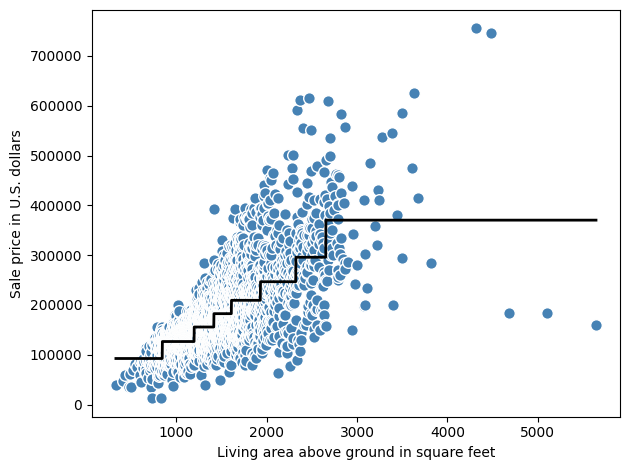

In [130]:
from sklearn.tree import DecisionTreeRegressor

X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')

plt.tight_layout()
#plt.savefig('figures/09_15.png', dpi=300)
plt.show()

In [131]:
tree_r2 = r2_score(y, tree.predict(X))
tree_r2

0.5144569334885711

- The decision tree regressor did not capture the continuity and differentiability of the desired prediction. 

In [117]:
df.columns

Index(['Overall Qual', 'Overall Cond', 'Total Bsmt SF', 'Central Air',
       'Gr Liv Area', 'SalePrice'],
      dtype='object')

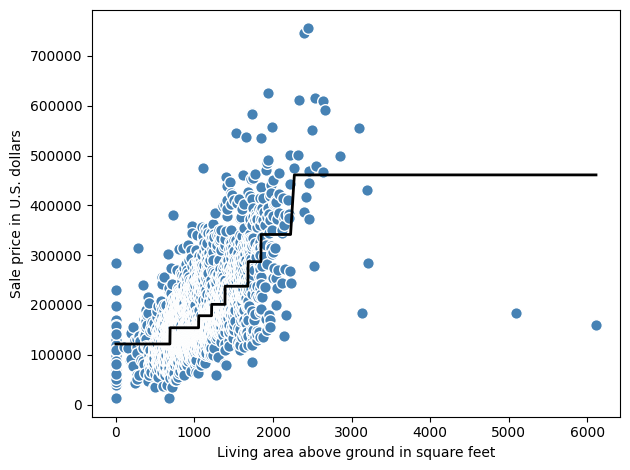

In [128]:
X = df[['Total Bsmt SF']].values
y = df['SalePrice'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')

plt.tight_layout()
#plt.savefig('figures/09_15.png', dpi=300)
plt.show()

In [129]:
tree_r2 = r2_score(y, tree.predict(X))
tree_r2

0.4844710822705274

### **Random forest regression**

- Ensemble technique that combines multiple decision trees.
  
- Better generalization performance than an individual decision tree due to randomness, which helps to decrease the model's variance.

- less sensitive to outliers.
  
- Doesn't require much parameter tuning.
  
- Experiment with the number of trees in the ensemble.
  
- MSE criterion to grow the individual decision trees, and the predicted target variable is calculated as the average prediction across all decision trees.

In [132]:
target = 'SalePrice'
features = df.columns[df.columns != target]

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)

In [133]:
X_train.shape, X_test.shape

((2050, 5), (879, 5))

In [134]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='squared_error', 
                               random_state=1, 
                               n_jobs=-1)

forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)


mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')


r2_train = r2_score(y_train, y_train_pred)
r2_test =r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

MAE train: 8305.26
MAE test: 20823.86
R^2 train: 0.98
R^2 test: 0.85


- Unfortunately, you can see that the random forest tends to overfit the training data.
- It's still able to explain the relationship between the target and explanatory variables relatively well ($R^{2} = 0.85 on the test dataset).

- Residuals of the prediction:

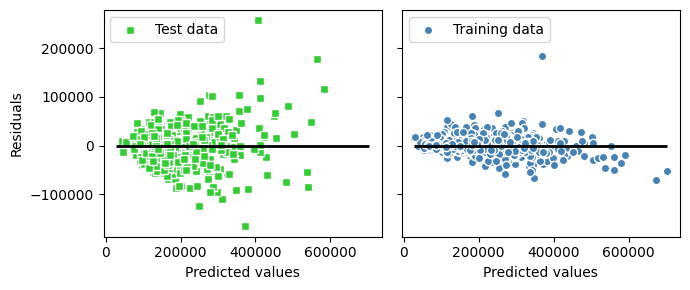

In [135]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')

ax2.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')

ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()

#plt.savefig('figures/09_16.png', dpi=300)
plt.show()

Ideally, our model error should be random or unpredictable. In other words, the error of the predictions should not be related to any of the information contained in the explanatory variables; rather, it should reflect the randomness of the real-world distributions or patterns. If we find patterns in the prediction errors, for example, by inspecting the residual plot, it means that the residual plots contain predictive information. A common reason for this could be that explanatory information is leaking into those residuals.

Unfortunately, there is not a universal approach for dealing with non-randomness in residual plots, and it requires experimentation. Depending on the data that is available to us, we may be able to improve the model by transforming variables, tuning the hyperparameters of the learning algorithm, choosing simpler or more complex models, removing outliers, or including additional variables.